# 第一课-第三周编程作业-带有一个隐藏层的平面数据分类

## 涉及到以下知识:
* 具有单隐藏层的二分类神经网络。
* 具有非线性激活功能激活函数，例如tanh。
* 交叉熵损失（损失函数）。
* 向前和向后传播。

## 0.1 准备软件包
* numpy: 是用Python进行科学计算的基本软件包
* sklearn: 为数据挖掘和数据分析提供的简单高效的工具
* matplotlib: 是一个用于在Python中描绘图表的库
* testCases: 提供了一些测试示例来评估函数的正确性
* planar_utils: 提供了在这个任务中使用的各种有用的函数

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
%matplotlib inline

np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。

## 0.2 加载和查看数据集

X的维度为: (2, 400)
Y的维度为: (1, 400)
数据集里面的数据有：400 个


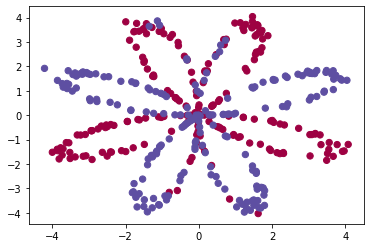

In [2]:
# 加载数据集
X, Y = load_planar_dataset()
# 可视化数据集
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral) #绘制散点图
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]  # 训练集里面的数量
print ("X的维度为: " + str(shape_X))
print ("Y的维度为: " + str(shape_Y))
print ("数据集里面的数据有：" + str(m) + " 个")

   数据看起来像一朵红色(y = 0)和蓝色(y = 1)的数据点的花朵的图案。我们的目标是建立一个模型来适应这些数据。
   * X: 一个numpy的矩阵，包含了这些数据点的数值
   * Y: 一个numpy的向量，对应着的是X的标签【0|1】(红色：0，蓝色：1)

## 0.3 查看简单的Logistic回归的分类效果

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


逻辑回归的准确性： 47 % (正确标记的数据点所占的百分比)


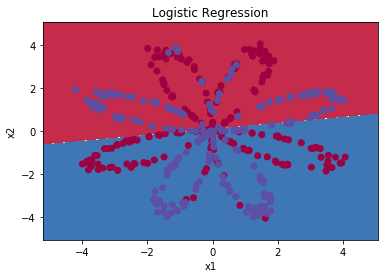

In [3]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,Y.T)

plot_decision_boundary(lambda x: clf.predict(x), X, Y) #绘制决策边界
plt.title("Logistic Regression") #图标题
LR_predictions  = clf.predict(X.T) #预测结果
print ("逻辑回归的准确性： %d " % float((np.dot(Y, LR_predictions) + 
		np.dot(1 - Y,1 - LR_predictions)) / float(Y.size) * 100) +
       "% " + "(正确标记的数据点所占的百分比)")

---
## 搭建神经网络
构建的神经网络结构如下图：
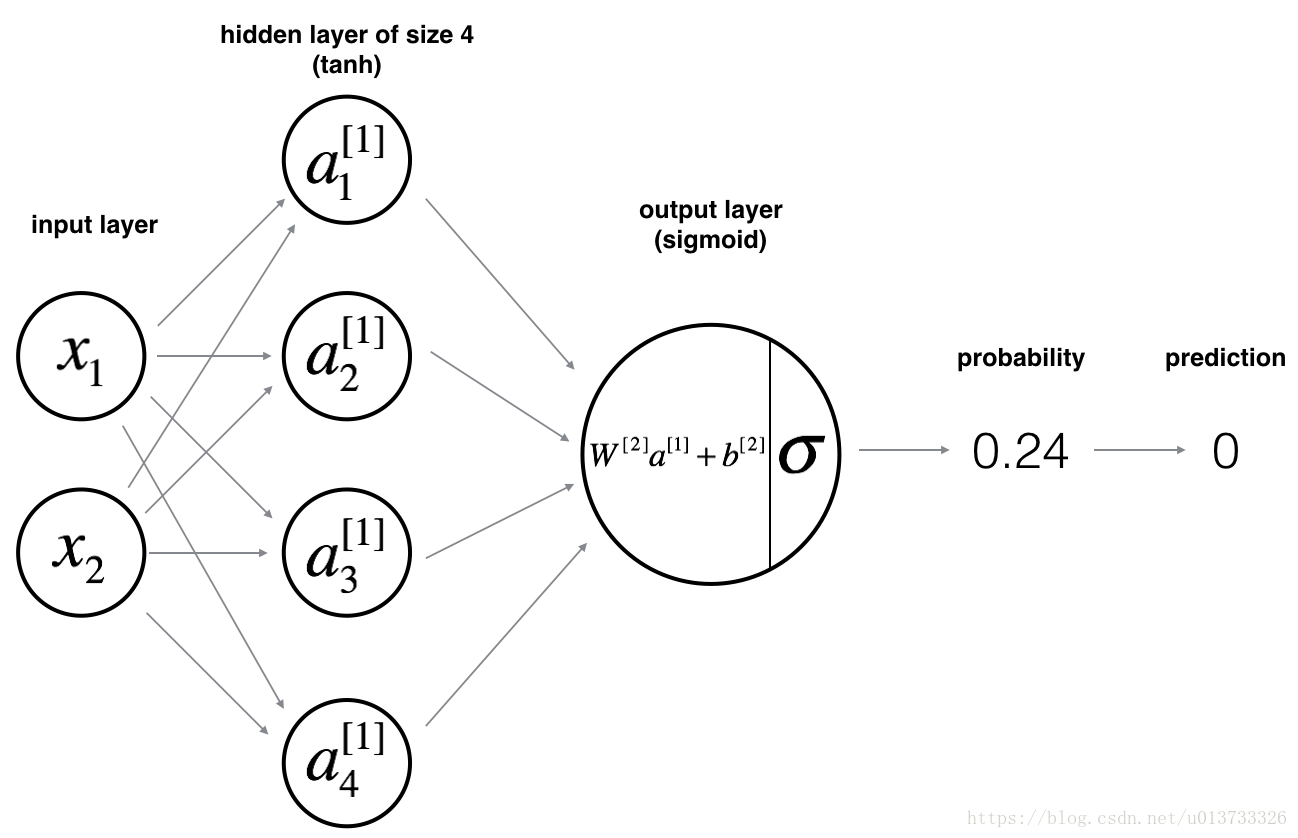

对于$x^{(i)}$而言：
$$
z^{[1](i)} = W^{[1]}x^{(i)} + b^{[1](i)} \\
a^{[1](i)} = tanh(z^{[1](i)}) \\
z^{[2](i)} = W^{[2]}a^{[1](i)} + b^{[2](i)} \\
\hat{y}^{(i)} = a^{[2](i)} = \sigma(z^{[2](i)})
$$
计算成本`J`:
$$
J = -\frac{1}{m} \sum_{i = 0}^m(y^{(i)}log(a^{a[2](i)}) + (1 - y^{(i)})log(1 - a^{a[2](i)}))
$$

**构建神经网络的一般方法是：**
1. 定义神经网络结构（输入单元的数量，隐藏单元的数量登）
2. 初始化模型的参数
3. 循环：
  * 3.1 实施前向传播
  * 3.2 计算损失Loss和成本Cost
  * 3.3 实现向后传播
  * 3.4 更新参数 （梯度下降`Gradient Descent`）

## 1. 定义神经网络结构

* n_x: 输入层元素的数量
* n_h: 隐藏层元素的数量（这里为4）
* n_y: 输出层元素的数量

In [4]:
def layer_sizes(X , Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）
    
    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] #输入层
    n_h = 4 #，隐藏层，硬编码为4
    n_y = Y.shape[0] #输出层
    
    return (n_x,n_h,n_y)

#测试layer_sizes
print("=========================测试layer_sizes=========================")
X_asses , Y_asses = layer_sizes_test_case()
(n_x,n_h,n_y) =  layer_sizes(X_asses,Y_asses)
print("输入层的节点数量为: n_x = " + str(n_x))
print("隐藏层的节点数量为: n_h = " + str(n_h))
print("输出层的节点数量为: n_y = " + str(n_y))

=========================测试layer_sizes=========================
输入层的节点数量为: n_x = 5
隐藏层的节点数量为: n_h = 4
输出层的节点数量为: n_y = 2


## 2. 初始化模型的参数
实现`initialize_parameters()`:

使用随机值初始化权重矩阵  
  * `np.random.randn(a, b) * 0.01`

将偏向量初始化为零
  
  * `np.zeros((a,b))`

In [5]:
def initialize_parameters( n_x , n_h ,n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量
    
    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(2) #指定一个随机种子，以便你的输出与我们的一样。
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    #使用断言确保我的数据格式是正确的
    assert(W1.shape == ( n_h , n_x ))
    assert(b1.shape == ( n_h , 1 ))
    assert(W2.shape == ( n_y , n_h ))
    assert(b2.shape == ( n_y , 1 ))
    
    parameters = {"W1" : W1,
                  "b1" : b1,
                  "W2" : W2,
                  "b2" : b2 }
    
    return parameters

#测试initialize_parameters
print("=========================测试initialize_parameters=========================")    
n_x , n_h , n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x , n_h , n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试initialize_parameters=========================
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


## 3. 循环
### 3.1 前向传播 `forward_propagation`
步骤如下：
* 使用字典类型的`parameters`检索每个参数
* 实现向前传播，计算$Z^{[1]},A^{[1]},Z^{[2]}和A^{[2]}$
* 反向传播所需的值存储在`cache`中,作为反向传播函数的输入

In [6]:
def forward_propagation( X , parameters ):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出
    
    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #前向传播计算A2
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    #使用断言确保我的数据格式是正确的
    assert(A2.shape == (1,X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return (A2, cache)

#测试forward_propagation
print("=========================测试forward_propagation=========================") 
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"]))

=========================测试forward_propagation=========================
-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431


### 3.2 计算损失、成本
计算成本`J`:
$$
J = -\frac{1}{m} \sum_{i = 0}^m(y^{(i)}log(a^{a[2](i)}) + (1 - y^{(i)})log(1 - a^{a[2](i)}))
$$

In [7]:
def compute_cost(A2,Y,parameters):
    """
    计算方程（6）中给出的交叉熵成本，
    
    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量
    
    返回：
         成本 - 交叉熵成本给出方程（13）
    """
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    #计算成本
    logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
    
    assert(isinstance(cost,float))
    
    return cost

#测试compute_cost
print("=========================测试compute_cost=========================") 
A2 , Y_assess , parameters = compute_cost_test_case()
print("cost = " + str(compute_cost(A2,Y_assess,parameters)))

=========================测试compute_cost=========================
cost = 0.6929198937761266


### 3.3 向后传播 `backward_propagation`
以下为视频中计算梯度的幻灯片:
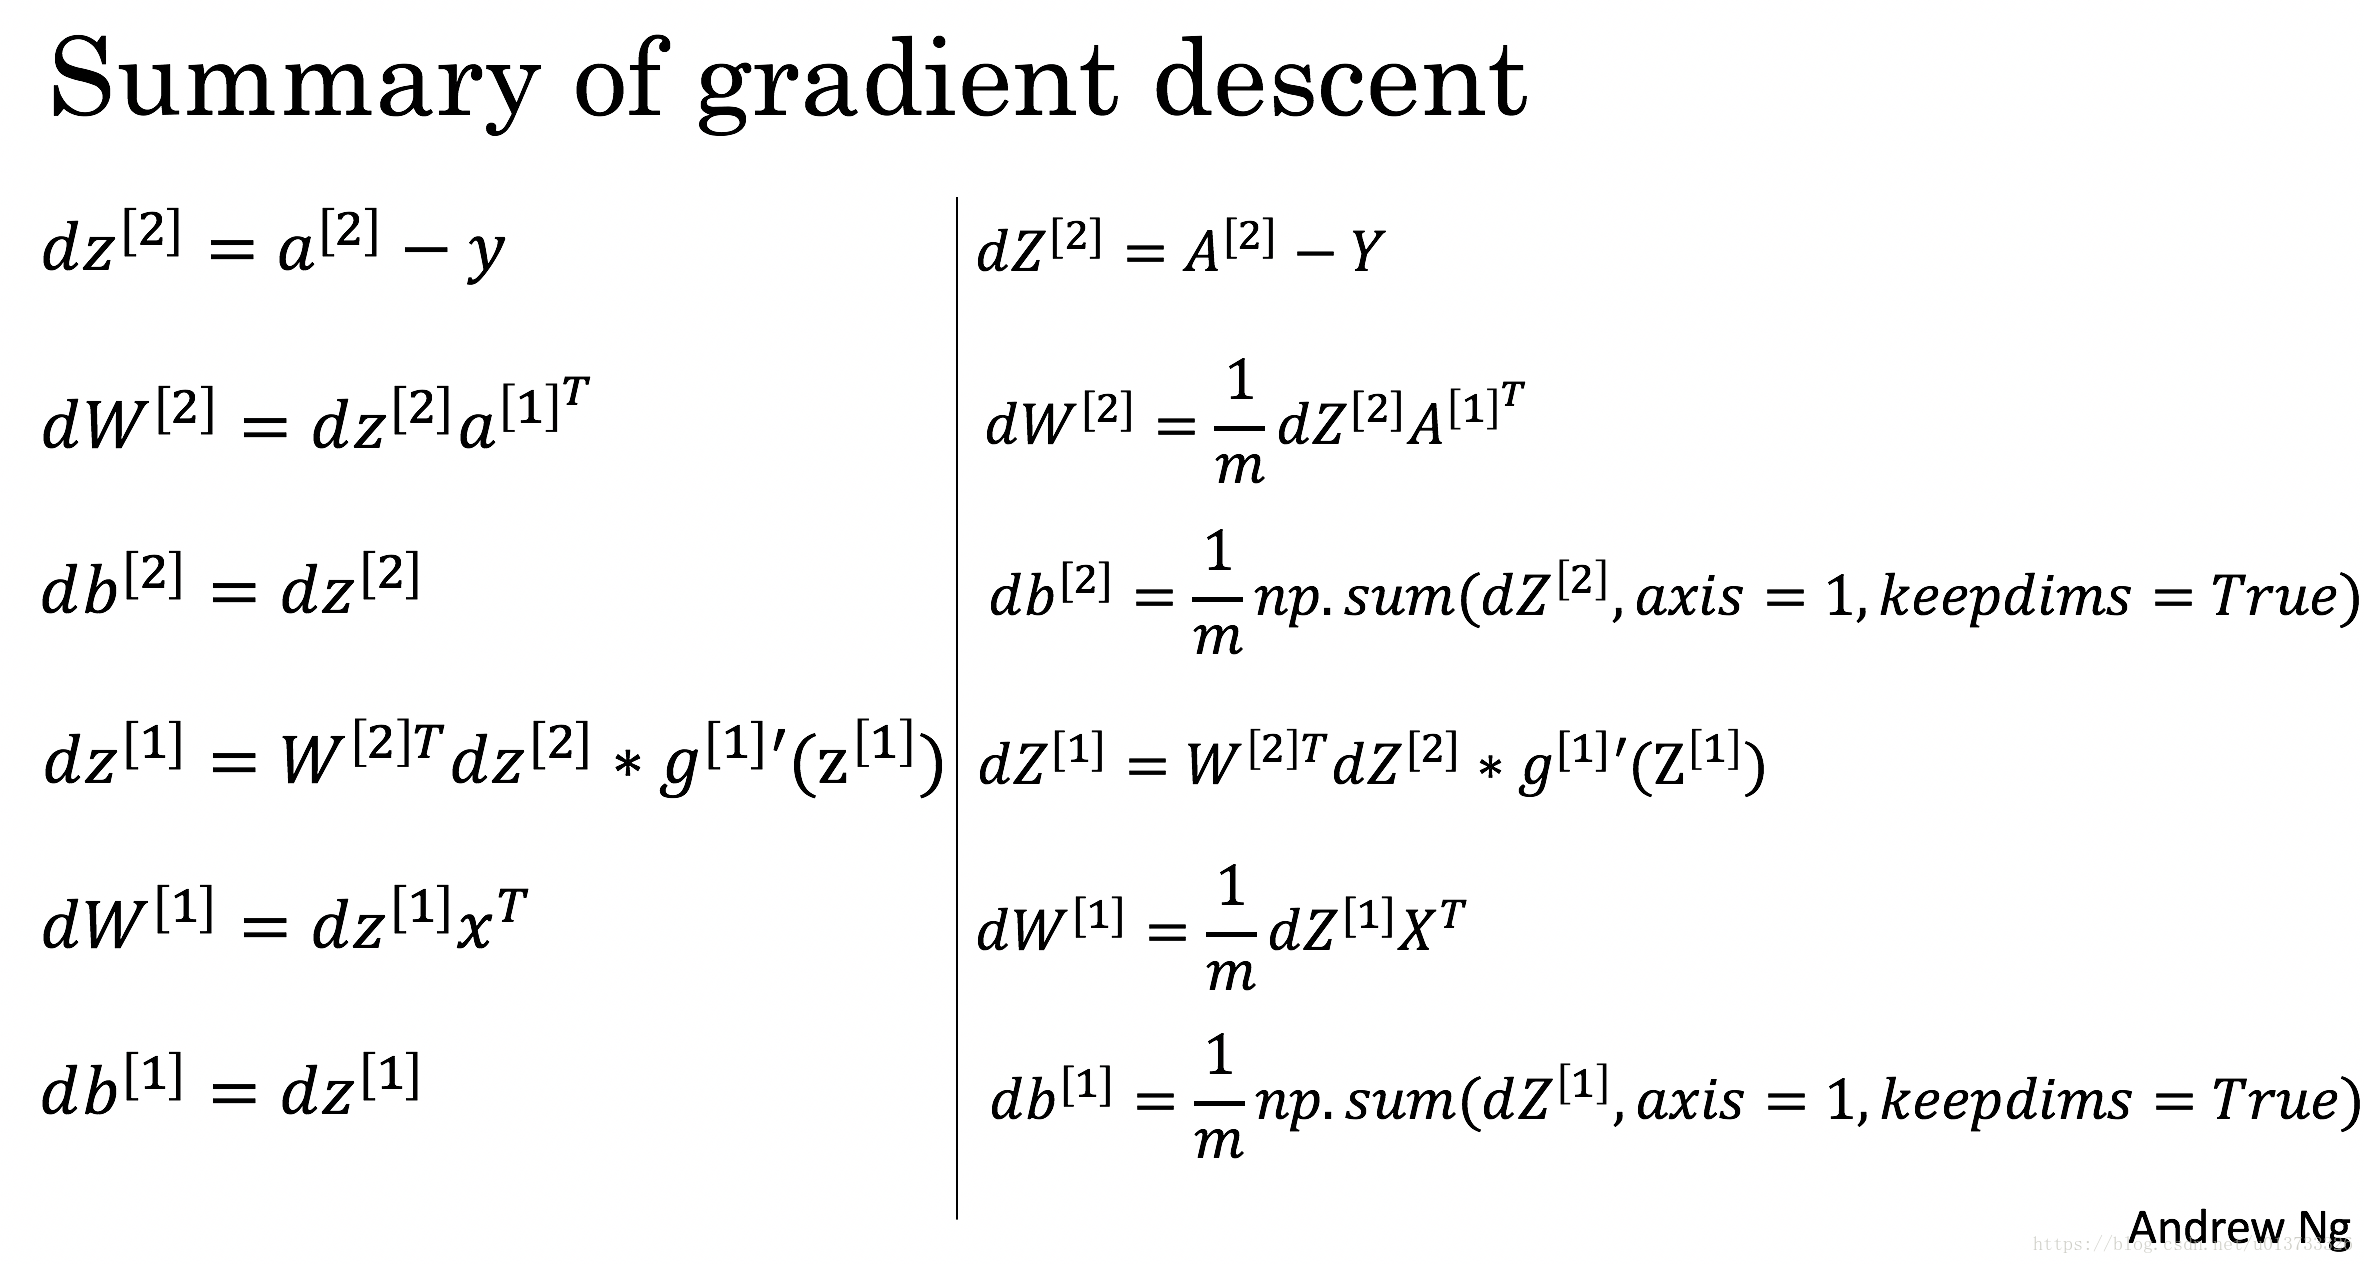

In [8]:
def backward_propagation(parameters,cache,X,Y):
    """
    使用上述说明搭建反向传播函数。
    
    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）
    
    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }
    
    return grads

#测试backward_propagation
print("=========================测试backward_propagation=========================")
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

=========================测试backward_propagation=========================
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


### 3.4 更新参数

In [9]:
def update_parameters(parameters,grads,learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数
    
    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率
    
    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]
    
    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

#测试update_parameters
print("=========================测试update_parameters=========================")
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试update_parameters=========================
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


## 整合

In [10]:
def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值
    
    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """
     
    np.random.seed(3) #指定随机种子
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    for i in range(num_iterations):
        A2 , cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)
        
        if print_cost:
            if i%1000 == 0:
                print("第 ",i," 次循环，成本为："+str(cost))
    return parameters

#测试nn_model
print("=========================测试nn_model=========================")
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试nn_model=========================


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
D:\360MoveData\Users\38004\Desktop\MyIPythonNotebook\Course1_神经网络和深度学习\编程作业\work2\planar_utils.py:31: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-3.89167767  4.77541602]
 [-6.77960338  1.20272585]
 [-3.88338966  4.78028666]
 [ 6.77958203 -1.20272574]]
b1 = [[ 2.11530892]
 [ 3.41221357]
 [ 2.11585732]
 [-3.41221322]]
W2 = [[-2512.9093032  -2502.70799785 -2512.01655969  2502.65264416]]
b2 = [[-22.29071761]]


## 预测

In [11]:
def predict(parameters, X):
    """
    使用学习的参数，为X中的每一个example预测一个类
    参数：
        parameters - 包含参数的字典类型的变量
        X - 输入数据 (n_x, m)
    返回：
        predictions - 我们模型预测的向量
    """
    A2, prediction = forward_propagation(X, parameters)
    predicteions = np.round(A2)
    
    return predicteions

#测试predict
print("=========================测试predict=========================")
parameters, X_assess = predict_test_case()
predictions = predict(parameters, X_assess)
print("预测的平均值 = " + str(np.mean(predictions)))

=========================测试predict=========================
预测的平均值 = 0.6666666666666666


## 正式运行

第  0  次循环，成本为：0.6930480201239823
第  1000  次循环，成本为：0.3098018601352803
第  2000  次循环，成本为：0.2924326333792646
第  3000  次循环，成本为：0.2833492852647412
第  4000  次循环，成本为：0.27678077562979253
第  5000  次循环，成本为：0.26347155088593144
第  6000  次循环，成本为：0.24204413129940763
第  7000  次循环，成本为：0.23552486626608762
第  8000  次循环，成本为：0.23140964509854278
第  9000  次循环，成本为：0.22846408048352365
准确率: 90%


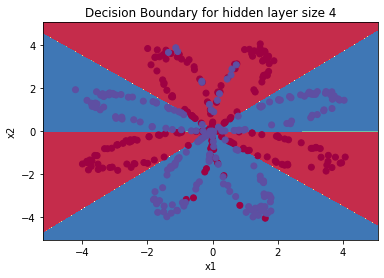

In [12]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)
#绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

## 更改隐藏节点数量

隐藏层的节点数量： 1  ，准确率: 67.25 %
隐藏层的节点数量： 2  ，准确率: 66.5 %
隐藏层的节点数量： 3  ，准确率: 89.25 %
隐藏层的节点数量： 4  ，准确率: 90.0 %
隐藏层的节点数量： 5  ，准确率: 89.75 %
隐藏层的节点数量： 20  ，准确率: 90.0 %
隐藏层的节点数量： 50  ，准确率: 89.75 %


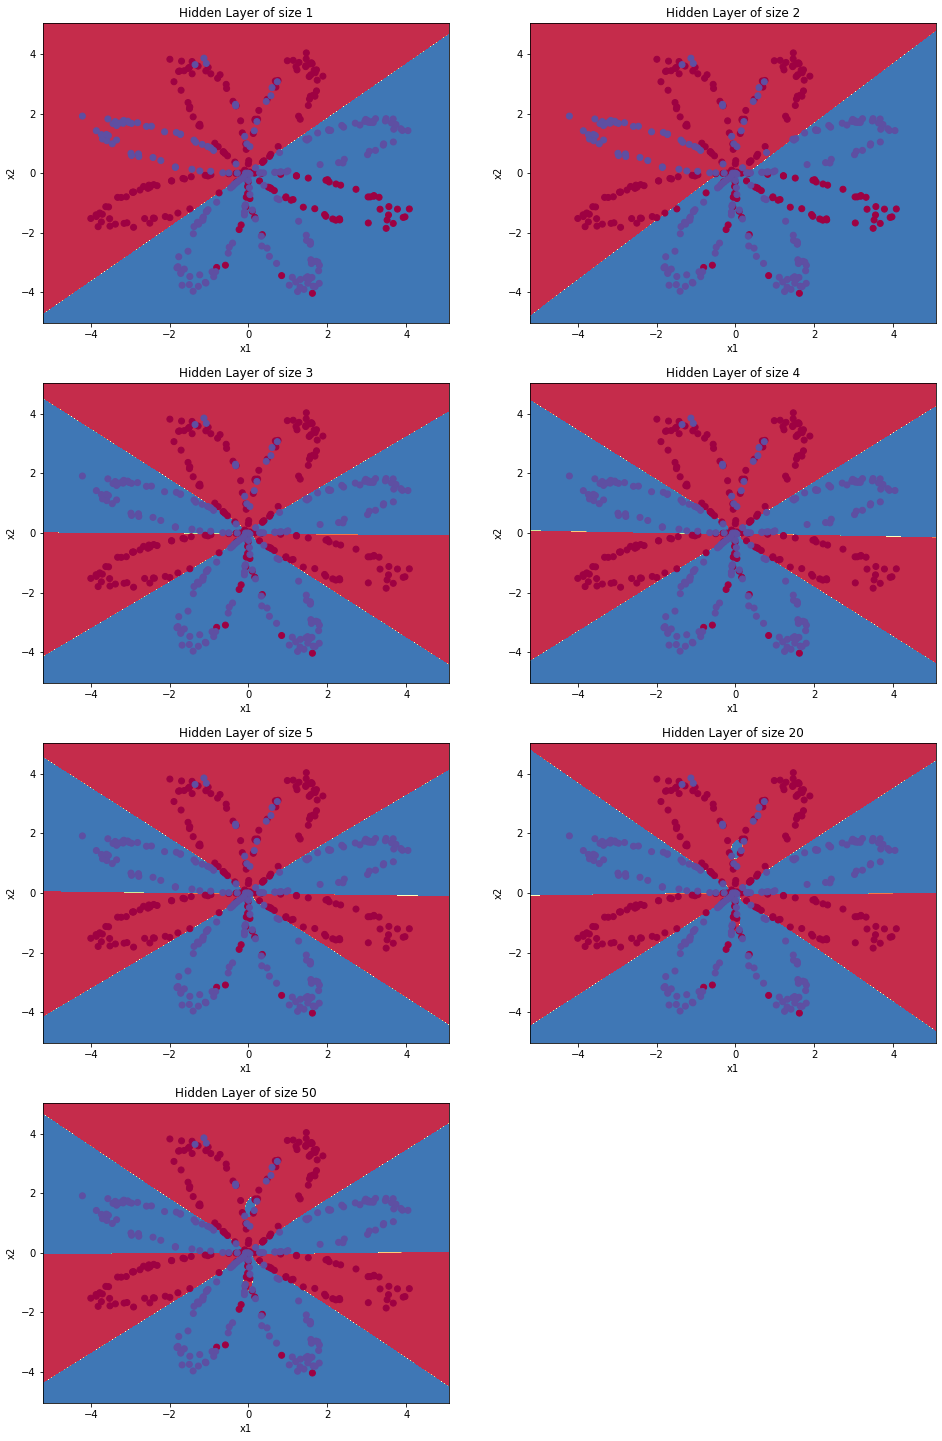

In [13]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] #隐藏层数量
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
    print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))

## 完整代码

### (1). 作业代码

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
%matplotlib inline

np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。

X, Y = load_planar_dataset()
#plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral) #绘制散点图
shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]  # 训练集里面的数量

print ("X的维度为: " + str(shape_X))
print ("Y的维度为: " + str(shape_Y))
print ("数据集里面的数据有：" + str(m) + " 个")

def layer_sizes(X , Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）

    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] #输入层
    n_h = 4 #，隐藏层，硬编码为4
    n_y = Y.shape[0] #输出层

    return (n_x,n_h,n_y)

def initialize_parameters( n_x , n_h ,n_y):
    """
    参数：
        n_x - 输入节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量

    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(2) #指定一个随机种子，以便你的输出与我们的一样。
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    #使用断言确保我的数据格式是正确的
    assert(W1.shape == ( n_h , n_x ))
    assert(b1.shape == ( n_h , 1 ))
    assert(W2.shape == ( n_y , n_h ))
    assert(b2.shape == ( n_y , 1 ))

    parameters = {"W1" : W1,
                  "b1" : b1,
                  "W2" : W2,
                  "b2" : b2 }

    return parameters

def forward_propagation(X , parameters):
    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出

    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
     """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    #前向传播计算A2
    Z1 = np.dot(W1 , X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2 , A1) + b2
    A2 = sigmoid(Z2)
    #使用断言确保我的数据格式是正确的
    assert(A2.shape == (1,X.shape[1]))
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return (A2, cache)

def compute_cost(A2,Y,parameters):
    """
    计算方程（6）中给出的交叉熵成本，

    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量

    返回：
         成本 - 交叉熵成本给出方程（13）
    """

    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    #计算成本
    logprobs = logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    cost = float(np.squeeze(cost))

    assert(isinstance(cost,float))

    return cost

def backward_propagation(parameters,cache,X,Y):
    """
    使用上述说明搭建反向传播函数。

    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）

    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]

    W1 = parameters["W1"]
    W2 = parameters["W2"]

    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2 }

    return grads

def update_parameters(parameters,grads,learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数

    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率

    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]

    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值

    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """

    np.random.seed(3) #指定随机种子
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(num_iterations):
        A2 , cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y,parameters)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate = 0.5)

        if print_cost:
            if i%1000 == 0:
                print("第 ",i," 次循环，成本为："+str(cost))
    return parameters

def predict(parameters,X):
    """
    使用学习的参数，为X中的每个示例预测一个类

    参数：
        parameters - 包含参数的字典类型的变量。
        X - 输入数据（n_x，m）

    返回
        predictions - 我们模型预测的向量（红色：0 /蓝色：1）

     """
    A2 , cache = forward_propagation(X,parameters)
    predictions = np.round(A2)

    return predictions

parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

#绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
print ('准确率: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')


# plt.figure(figsize=(16, 32))
# hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50] #隐藏层数量
# for i, n_h in enumerate(hidden_layer_sizes):
#     plt.subplot(5, 2, i + 1)
#     plt.title('Hidden Layer of size %d' % n_h)
#     parameters = nn_model(X, Y, n_h, num_iterations=5000)
#     plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
#     predictions = predict(parameters, X)
#     accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)
#     print ("隐藏层的节点数量： {}  ，准确率: {} %".format(n_h, accuracy))


### (2). testCases.py

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time : 2021/1/12 19:52
# @Author : Kai
# @File : testCases.py
# @Software: PyCharm
import numpy as np

def layer_sizes_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(5, 3)
    Y_assess = np.random.randn(2, 3)
    return X_assess, Y_assess

def initialize_parameters_test_case():
    n_x, n_h, n_y = 2, 4, 1
    return n_x, n_h, n_y

def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)

    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    return X_assess, parameters

def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = np.random.randn(1, 3)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    a2 = (np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]))

    return a2, Y_assess, parameters

def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    parameters = {'W1': np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]]),
     'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
     'b1': np.array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
     'b2': np.array([[ 0.]])}

    cache = {'A1': np.array([[-0.00616578,  0.0020626 ,  0.00349619],
         [-0.05225116,  0.02725659, -0.02646251],
         [-0.02009721,  0.0036869 ,  0.02883756],
         [ 0.02152675, -0.01385234,  0.02599885]]),
  'A2': np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]),
  'Z1': np.array([[-0.00616586,  0.0020626 ,  0.0034962 ],
         [-0.05229879,  0.02726335, -0.02646869],
         [-0.02009991,  0.00368692,  0.02884556],
         [ 0.02153007, -0.01385322,  0.02600471]]),
  'Z2': np.array([[ 0.00092281, -0.00056678,  0.00095853]])}
    return parameters, cache, X_assess, Y_assess

def update_parameters_test_case():
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
 'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
 'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
 'b2': np.array([[  9.14954378e-05]])}

    grads = {'dW1': np.array([[ 0.00023322, -0.00205423],
        [ 0.00082222, -0.00700776],
        [-0.00031831,  0.0028636 ],
        [-0.00092857,  0.00809933]]),
 'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03,
          -2.55715317e-03]]),
 'db1': np.array([[  1.05570087e-07],
        [ -3.81814487e-06],
        [ -1.90155145e-07],
        [  5.46467802e-07]]),
 'db2': np.array([[ -1.08923140e-05]])}
    return parameters, grads

def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    return X_assess, Y_assess

def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]),
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]),
     'b1': np.array([[ -8.97523455e-07],
        [  8.15562092e-06],
        [  6.04810633e-07],
        [ -2.54560700e-06]]),
     'b2': np.array([[  9.14954378e-05]])}
    return parameters, X_assess

### (3). planar_utils.py

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time : 2021/1/12 20:41
# @Author : Kai
# @File : planar_utils.py
# @Software: PyCharm
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral)


def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure